In [53]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
from io import StringIO
from tabulate import tabulate

import keras
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import Sequential
from keras import regularizers
from keras.utils import to_categorical

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv("Maternal Health Risk Data Set.csv")

print("Shape: ", df.shape)

df.head()

Shape:  (1014, 7)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
dis_info = StringIO()
df.info(buf=dis_info)
print(dis_info.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB



In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


In [5]:
df.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

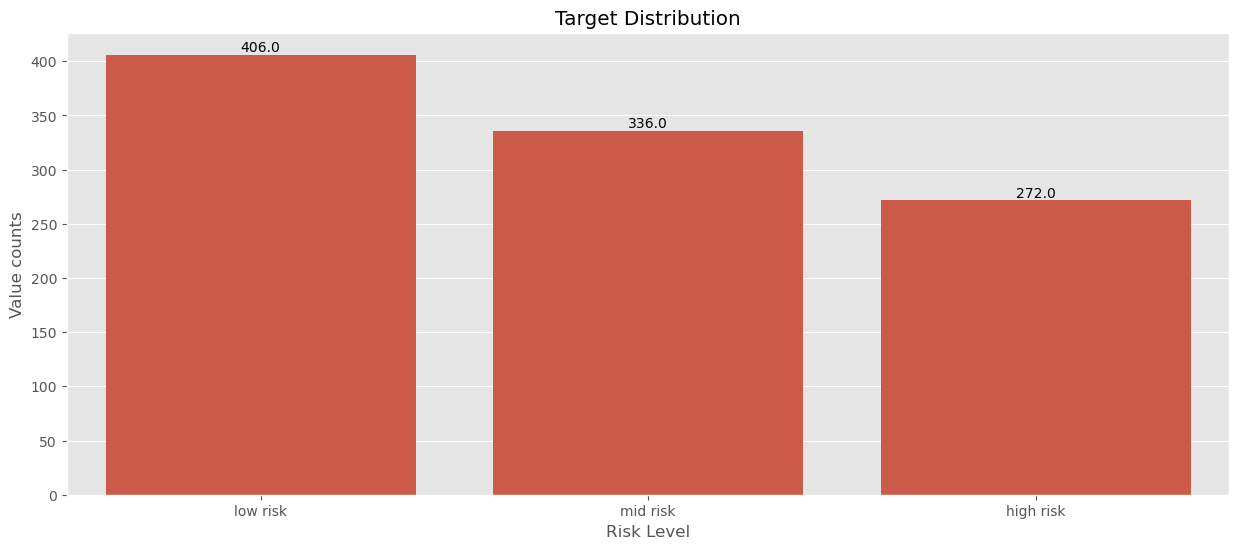

In [6]:
target_dist = df["RiskLevel"].value_counts()

fig, ax = plt.subplots(figsize=(15, 6))
bar_plt = sns.barplot(x=target_dist.index, y=target_dist.values,ax=ax)

for p in bar_plt.patches:
    h = p.get_height()
    bar_plt.text(p.get_x()+(p.get_width()/2), h, f"{h}", ha="center", va="bottom")

bar_plt.set_xlabel("Risk Level")
bar_plt.set_ylabel("Value counts")
bar_plt.set_title("Target Distribution")

plt.show()

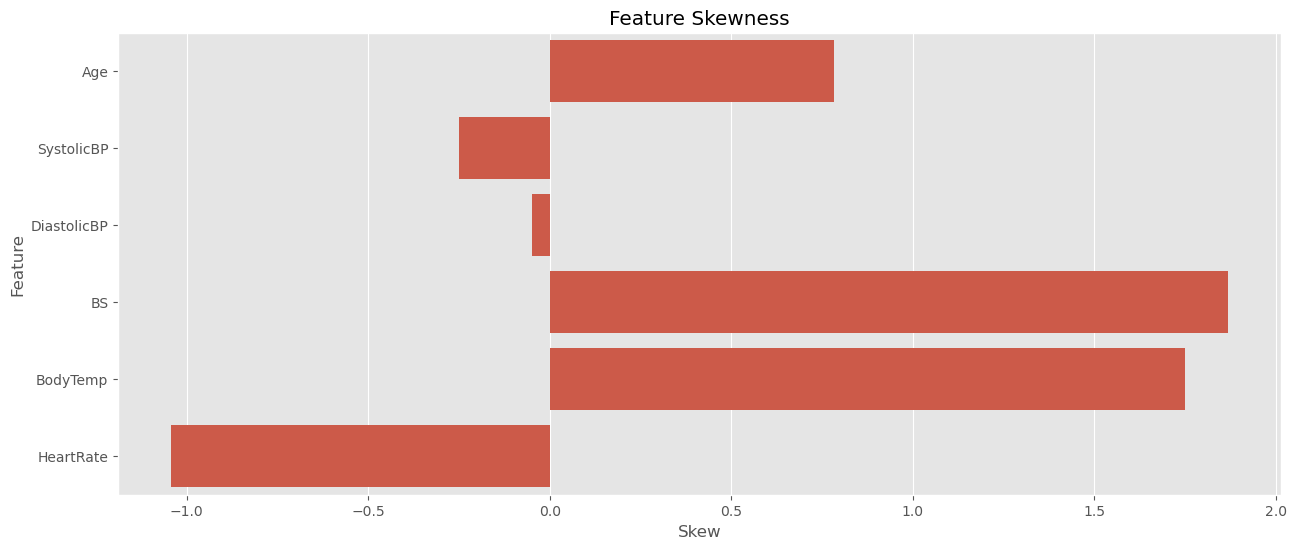

In [7]:
skewness = df.iloc[:, :-1].skew()

fig, ax = plt.subplots(figsize=(15, 6))
bar_plt = sns.barplot(y=skewness.index, x=skewness.values,ax=ax)

bar_plt.set_xlabel("Skew")
bar_plt.set_ylabel("Feature")
bar_plt.set_title("Feature Skewness")

plt.show()

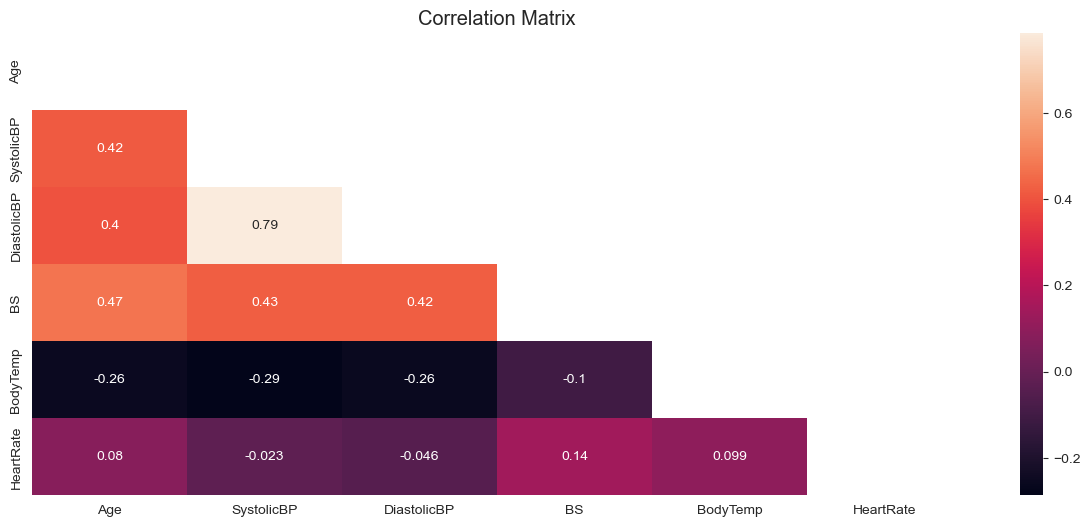

In [8]:
plt.figure(figsize=(15, 6))
df_corr = df.iloc[:, :-1].corr()
sns.set_style("white")
sns.heatmap(df_corr, annot=True, mask=np.triu(np.ones(df_corr.shape)), )
plt.title("Correlation Matrix")
plt.show()

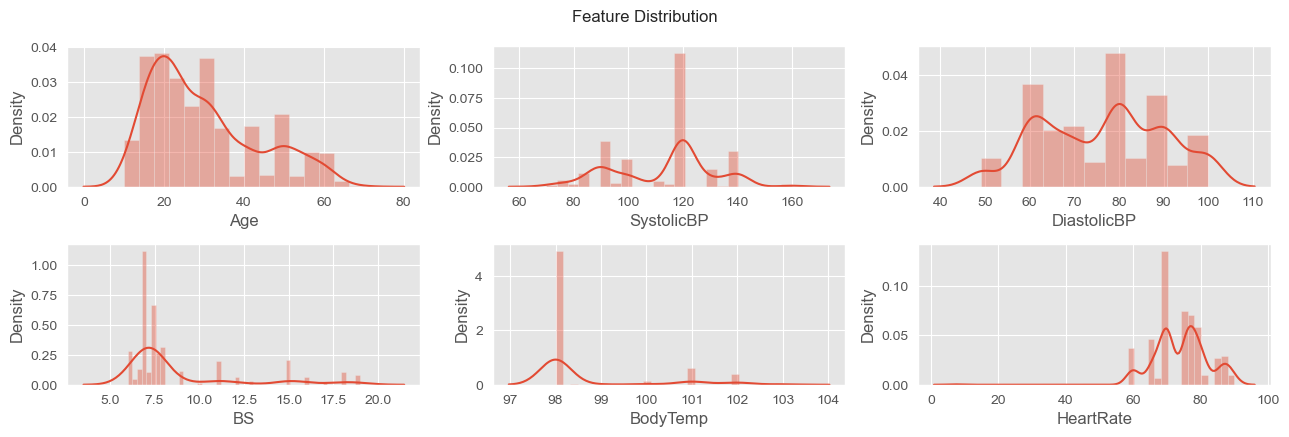

In [9]:
plt.style.use("ggplot")

plt.figure(figsize=(13, 6))
for idx, col_name in enumerate(df.iloc[:, :-1].columns, start=1):
    plt.subplot(3, 3, idx)
    sns.distplot(df[col_name])

plt.suptitle("Feature Distribution")
plt.tight_layout()
plt.show()

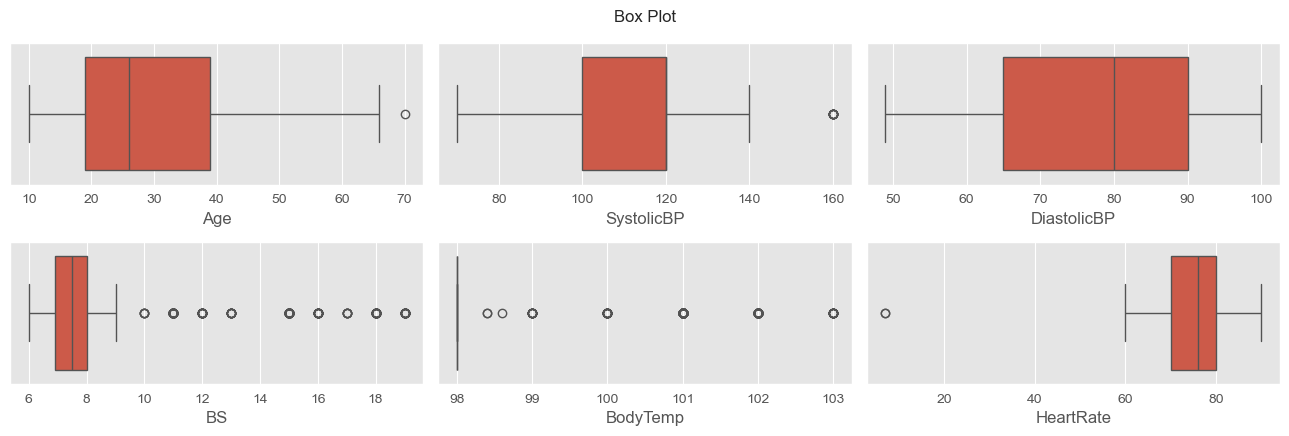

In [10]:
plt.style.use("ggplot")

plt.figure(figsize=(13, 6))
for idx, col_name in enumerate(df.iloc[:, :-1].columns, start=1):
    plt.subplot(3, 3, idx)
    sns.boxplot(x=df[col_name])

plt.suptitle("Box Plot")
plt.tight_layout()
plt.show()

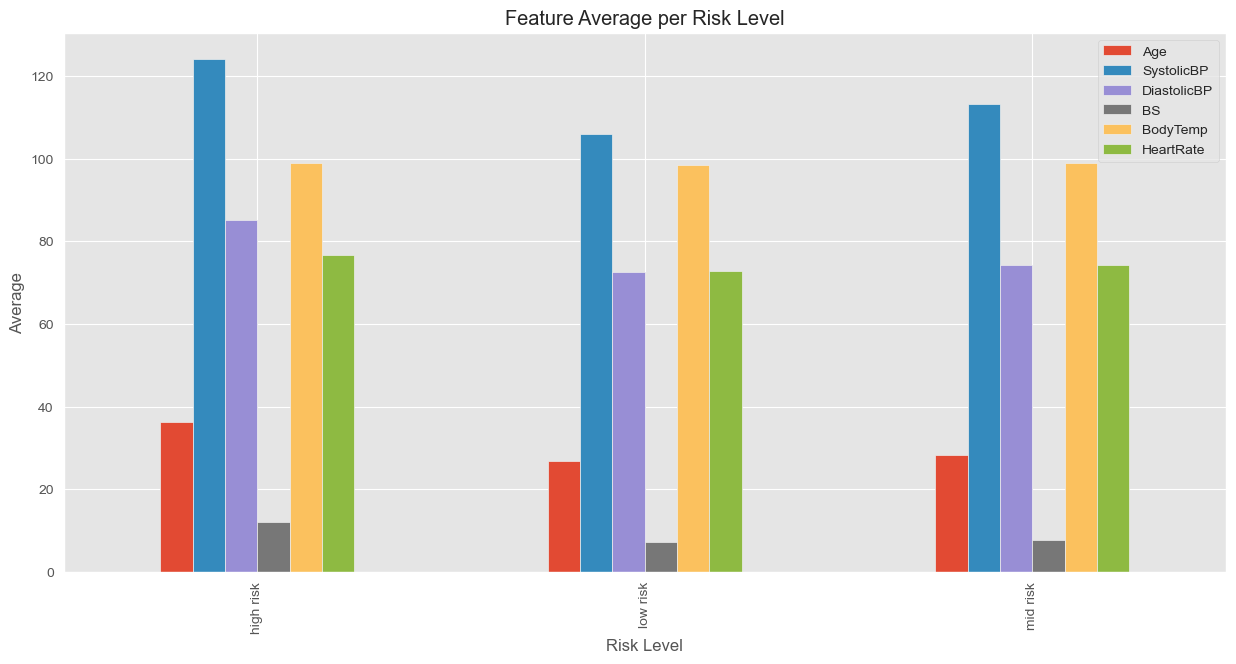

In [11]:
df.groupby("RiskLevel").mean().plot(kind="bar", 
                                    figsize=(15, 7),
                                    xlabel="Risk Level",
                                    ylabel="Average",
                                    title="Feature Average per Risk Level")
plt.show()

In [12]:
encoder = LabelEncoder()

df["RiskLevel"] = encoder.fit_transform(df["RiskLevel"])

In [13]:
y = df.pop("RiskLevel")
X = df

In [14]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [15]:
def Train_Algorithms(X, y, algo):
    stf = StratifiedKFold(n_splits=5)
    model_performance = {"F1_SCORE":[], "PRECISION":[], "RECALL":[], "ACCURACY":[]}
    model_names = []
    for algorithms in algo:
        init_algo = algorithms()
        
        F1_SCORE = []
        PRECISION = []
        RECALL = []
        ACCURACY = []
        for train_idx, test_idx in tqdm(stf.split(X, y), desc=f"{algorithms.__name__}", total=len(algo)):
            xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
            ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

            init_algo.fit(xtrain, ytrain)

            test_pred = init_algo.predict(xtest)

            F1_SCORE.append(metrics.f1_score(y_true=ytest, y_pred=test_pred, average="macro"))
            PRECISION.append(metrics.precision_score(y_true=ytest, y_pred=test_pred, average="macro"))
            RECALL.append(metrics.recall_score(y_true=ytest, y_pred=test_pred, average="macro"))
            ACCURACY.append(metrics.accuracy_score(y_true=ytest, y_pred=test_pred))

        model_names.append(algorithms.__name__)
        model_performance["F1_SCORE"].append(np.mean(F1_SCORE))
        model_performance["PRECISION"].append(np.mean(PRECISION))
        model_performance["RECALL"].append(np.mean(RECALL))
        model_performance["ACCURACY"].append(np.mean(ACCURACY))

    return tabulate(pd.DataFrame(model_performance).T,headers=[i.split("Classifier")[0] for i in model_names], tablefmt="double_grid")

In [16]:
model_list = [SVC, GaussianNB, MLPClassifier, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier]

In [17]:
print(Train_Algorithms(X, y, model_list))

XGBClassifier:  71%|█████████████████████████████████████████████████▎                   | 5/7 [00:02<00:00,  2.42it/s]

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦══════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║      XGB ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╣
║ F1_SCORE  ║ 0.682403 ║     0.567463 ║ 0.663175 ║       0.808423 ║       0.829852 ║           0.752731 ║ 0.819461 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╣
║ PRECISION ║ 0.702202 ║     0.613823 ║ 0.676974 ║       0.827233 ║       0.849199 ║           0.761397 ║ 0.841048 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╣
║ RECALL    ║ 0.691523 ║     0.585639 ║ 0.670841 ║       0.820995 ║       0.836792 ║           0.756158 ║ 0.829627 ║
╠═══════════╬══════════╬══════════════╬══════════╬══════════════

In [109]:
model = Sequential([
    layers.Input(shape=(X.shape[1], ), name="Input_layer"),
    layers.Dense(units=512, activation="relu", kernel_regularizer=regularizers.L1L2()),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation="relu",  kernel_regularizer=regularizers.L1L2()),
    layers.BatchNormalization(),
    layers.Dense(units=1024, activation="relu",  kernel_regularizer=regularizers.L1L2()),
    layers.Dropout(rate=0.5),
    layers.Dense(units=1024, activation="relu",  kernel_regularizer=regularizers.L1L2()),
    layers.Dropout(rate=0.5),
    layers.Dense(units=3, activation="softmax")
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               3584      
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 1024)             

In [110]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])

In [111]:
x_train, x_test, ytrain, ytest = train_test_split(X, to_categorical(y), stratify=to_categorical(y), test_size=0.1, random_state=0)

In [112]:
model_history = model.fit(x_train, ytrain,
                          validation_data=(x_test, ytest), 
                          epochs=100, 
                          callbacks=[callbacks.ReduceLROnPlateau(), callbacks.EarlyStopping(patience=5)])

Epoch 1/100
29/29 [==============================] - 3s 40ms/step - loss: 1.1713 - categorical_accuracy: 0.4474 - f1_score: 0.4419 - precision_13: 0.4609 - recall_13: 0.3487 - val_loss: 1.0322 - val_categorical_accuracy: 0.5588 - val_f1_score: 0.4822 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 26ms/step - loss: 1.0333 - categorical_accuracy: 0.5121 - f1_score: 0.5115 - precision_13: 0.5432 - recall_13: 0.4550 - val_loss: 0.9938 - val_categorical_accuracy: 0.5392 - val_f1_score: 0.5315 - val_precision_13: 1.0000 - val_recall_13: 0.0098 - lr: 1.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 24ms/step - loss: 1.0144 - categorical_accuracy: 0.5461 - f1_score: 0.5467 - precision_13: 0.5720 - recall_13: 0.4879 - val_loss: 0.9622 - val_categorical_accuracy: 0.5882 - val_f1_score: 0.5315 - val_precision_13: 1.0000 - val_recall_13: 0.0392 - lr: 1.0000e-04
Epoch 4/100
29/29 [================

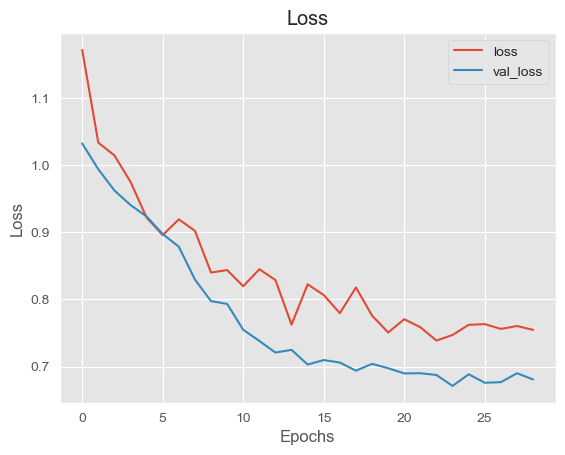

In [113]:
pd.DataFrame(model_history.history)[["loss", "val_loss"]].plot(xlabel="Epochs", ylabel="Loss", title="Loss")
plt.show()

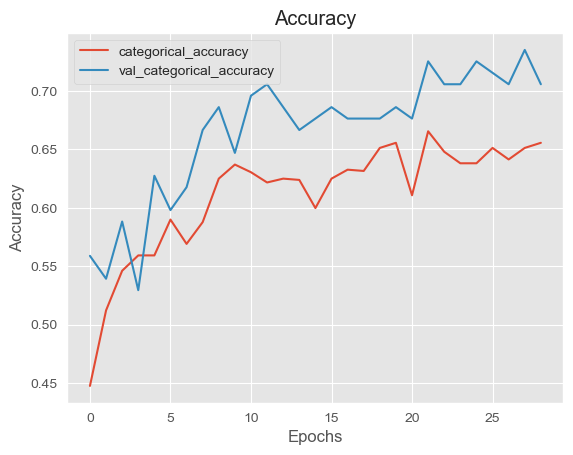

In [114]:
pd.DataFrame(model_history.history)[["categorical_accuracy", 
                                     "val_categorical_accuracy"]].plot(xlabel="Epochs", ylabel="Accuracy", title="Accuracy")
plt.show()

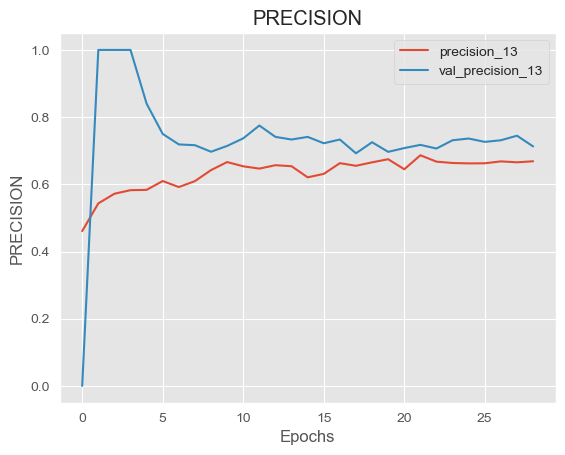

In [120]:
pd.DataFrame(model_history.history)[["precision_13", 
                                     "val_precision_13"]].plot(xlabel="Epochs", ylabel="PRECISION", title="PRECISION")
plt.show()